# Thư viện liên quan

In [1]:
import torch
import torchvision
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim

import numpy as np
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


# 1. Chuẩn bị dữ liệu (đã chia train/test sẵn)

In [2]:
def mask_to_bbox(mask):
    mask_np = np.array(mask)
    pet_mask = (mask_np == 1)  # chỉ lấy vùng foreground pet
    pos = np.where(pet_mask)
    if len(pos[0]) == 0:
        return [0, 0, 0, 0]
    ymin, xmin = np.min(pos[0]), np.min(pos[1])
    ymax, xmax = np.max(pos[0]), np.max(pos[1])
    return [xmin, ymin, xmax, ymax]

In [3]:
class PetDataset(torch.utils.data.Dataset):
    def __init__(self, root, split):
        self.dataset = OxfordIIITPet(root=root, split=split, target_types=('category', 'segmentation'), download=True)
        self.transforms = ToTensor()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, (label, mask) = self.dataset[idx]
        box = mask_to_bbox(mask)
        if box == [0, 0, 0, 0]:
            box = [0, 0, 1, 1]

        target = {}
        target['boxes'] = torch.tensor([box], dtype=torch.float32)
        target['labels'] = torch.tensor([label + 1])  # +1 vì 0 là background
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.tensor([(box[2] - box[0]) * (box[3] - box[1])], dtype=torch.float32)
        target['iscrowd'] = torch.zeros((1,), dtype=torch.int64)

        img = self.transforms(img)
        return img, target


train_dataset = PetDataset(root='./data', split='trainval')
test_dataset = PetDataset(root='./data', split='test')

In [4]:
idx_to_class = {
    1: 'Abyssinian',
    2: 'Bengal',
    3: 'Birman',
    4: 'Bombay',
    5: 'British_Shorthair',
    6: 'Egyptian_Mau',
    7: 'Maine_Coon',
    8: 'Persian',
    9: 'Ragdoll',
    10: 'Russian_Blue',
    11: 'Siamese',
    12: 'Sphynx',
    13: 'American_Bulldog',
    14: 'American_Pit_Bull_Terrier',
    15: 'Basset_Hound',
    16: 'Beagle',
    17: 'Boxer',
    18: 'Chihuahua',
    19: 'English_Cocker_Spaniel',
    20: 'English_Setter',
    21: 'German_Shorthaired',
    22: 'Golden_Retriever',
    23: 'Great_Pyrenees',
    24: 'Havanese',
    25: 'Japanese_Chin',
    26: 'Keeshond',
    27: 'Leonberger',
    28: 'Maltese',
    29: 'Pembroke',
    30: 'Pomeranian',
    31: 'Pug',
    32: 'Saint_Bernard',
    33: 'Samoyed',
    34: 'Scottish_Terrier',
    35: 'Shiba_Inu',
    36: 'Staffordshire_Bull_Terrier',
    37: 'Wheaten_Terrier'
}

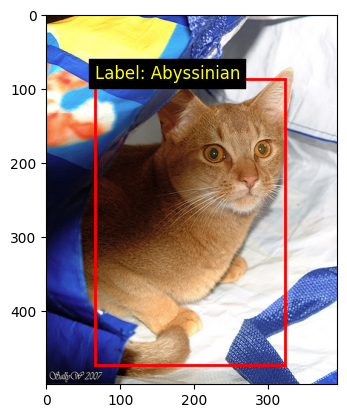

In [5]:
# Load 1 sample
img, target = train_dataset[0]
img = img.permute(1, 2, 0).numpy()  # CHW -> HWC

# Lấy bbox và label
bbox = target['boxes'][0].numpy()
label = target['labels'].item()
label_name = idx_to_class.get(label, 'Unknown')

fig, ax = plt.subplots(1)
ax.imshow(img)

# Vẽ bbox
xmin, ymin, xmax, ymax = bbox
rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                         linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

# Hiển thị tên label thay vì số
ax.text(xmin, ymin, f'Label: {label_name}', color='yellow', fontsize=12, backgroundcolor='black')

plt.show()

In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=3, shuffle=True, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn)

# 2. Chuẩn bị model Faster R-CNN pretrained với số class đúng (37 pet + 1 background)

In [7]:
num_classes = 38  # 37 classes + background

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# 3. Hàm huấn luyện 1 epoch

In [8]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0
    pbar = tqdm(data_loader, desc="Train Epoch")
    for images, targets in pbar:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        pbar.set_postfix(loss=total_loss / (pbar.n + 1))

    print(f"Train Loss: {total_loss / len(data_loader):.4f}")

# 4. Chạy huấn luyện và evaluate

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_one_epoch(model, optimizer, train_loader, device)

Epoch 1/10


Train Epoch: 100%|██████████| 1227/1227 [12:47<00:00,  1.60it/s, loss=0.244]


Train Loss: 0.2442
Epoch 2/10


Train Epoch: 100%|██████████| 1227/1227 [12:12<00:00,  1.67it/s, loss=0.171]


Train Loss: 0.1714
Epoch 3/10


Train Epoch: 100%|██████████| 1227/1227 [12:14<00:00,  1.67it/s, loss=0.141]


Train Loss: 0.1412
Epoch 4/10


Train Epoch: 100%|██████████| 1227/1227 [12:11<00:00,  1.68it/s, loss=0.125]


Train Loss: 0.1248
Epoch 5/10


Train Epoch: 100%|██████████| 1227/1227 [12:20<00:00,  1.66it/s, loss=0.11]


Train Loss: 0.1098
Epoch 6/10


Train Epoch: 100%|██████████| 1227/1227 [12:23<00:00,  1.65it/s, loss=0.102]


Train Loss: 0.1015
Epoch 7/10


Train Epoch: 100%|██████████| 1227/1227 [12:11<00:00,  1.68it/s, loss=0.0964]


Train Loss: 0.0964
Epoch 8/10


Train Epoch: 100%|██████████| 1227/1227 [12:16<00:00,  1.67it/s, loss=0.0896]


Train Loss: 0.0896
Epoch 9/10


Train Epoch: 100%|██████████| 1227/1227 [12:17<00:00,  1.66it/s, loss=0.0858]


Train Loss: 0.0858
Epoch 10/10


Train Epoch: 100%|██████████| 1227/1227 [12:13<00:00,  1.67it/s, loss=0.0843]

Train Loss: 0.0843


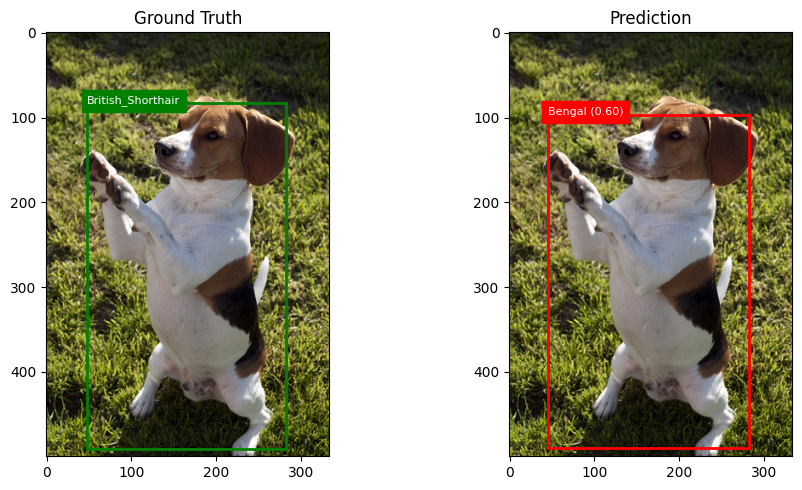

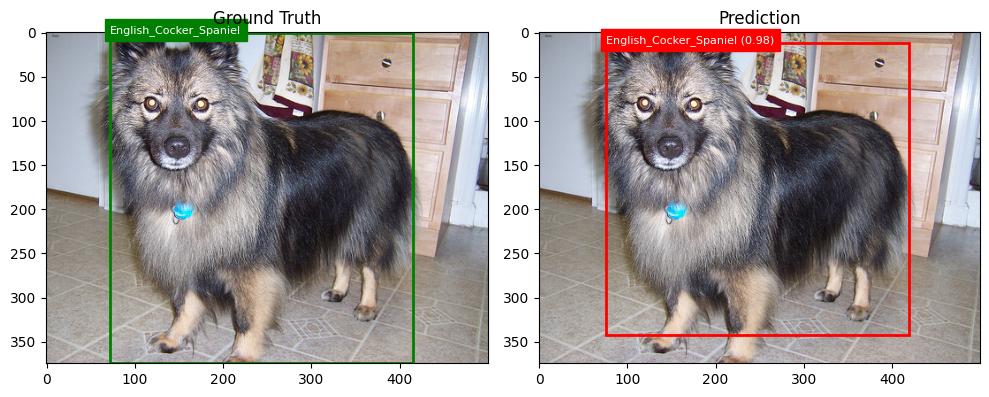

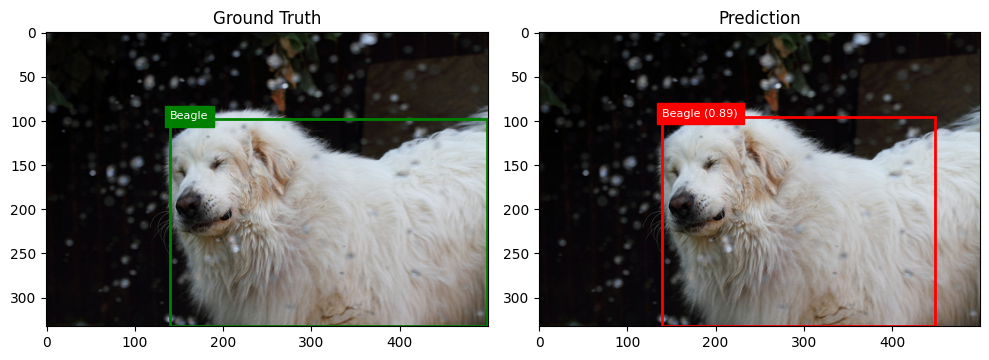

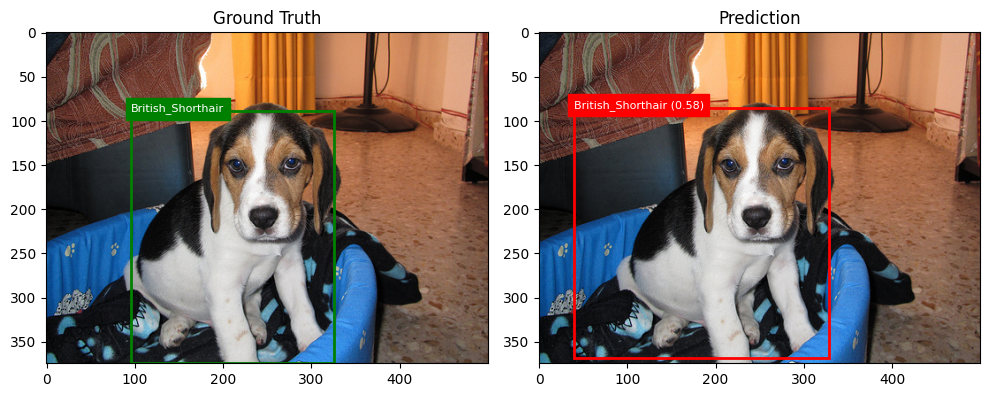

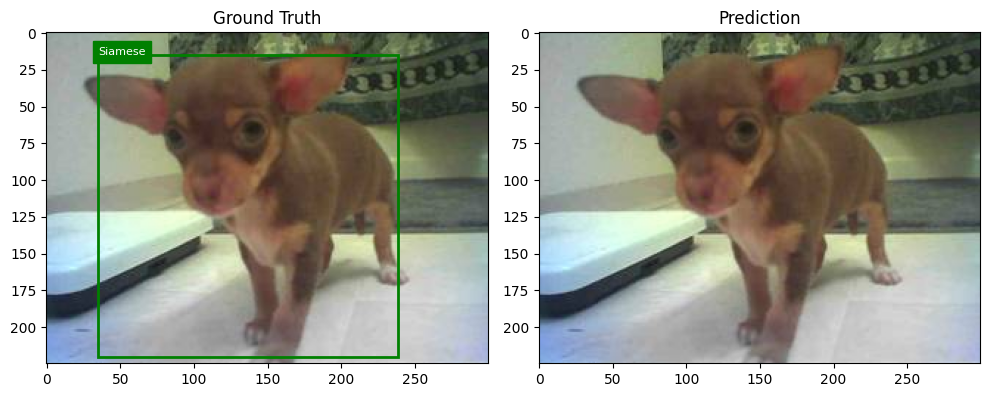

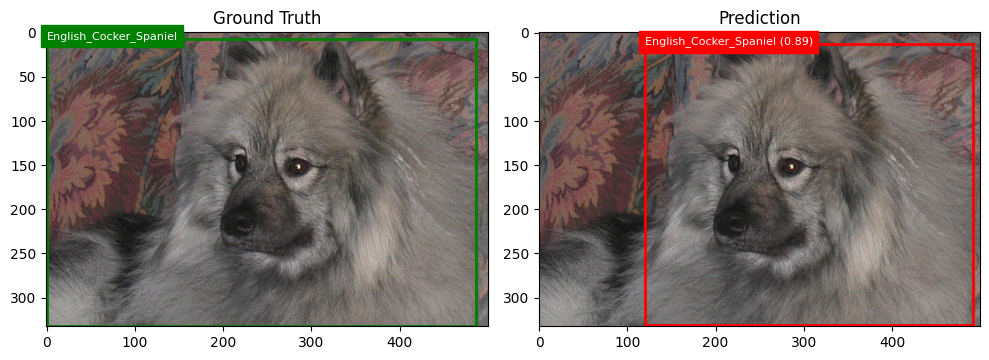

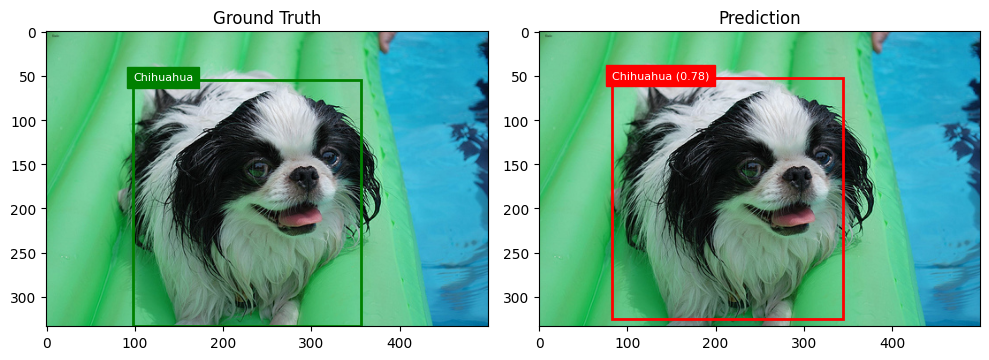

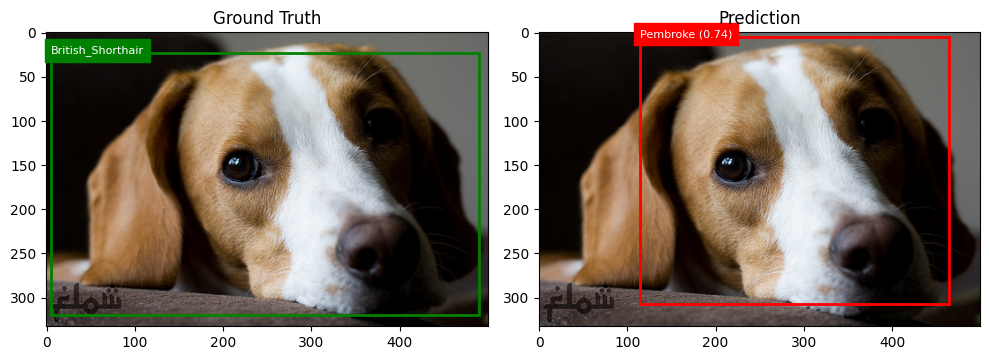

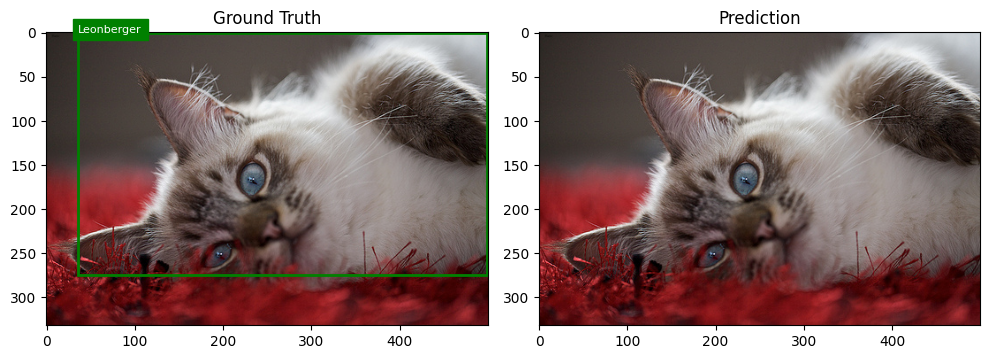

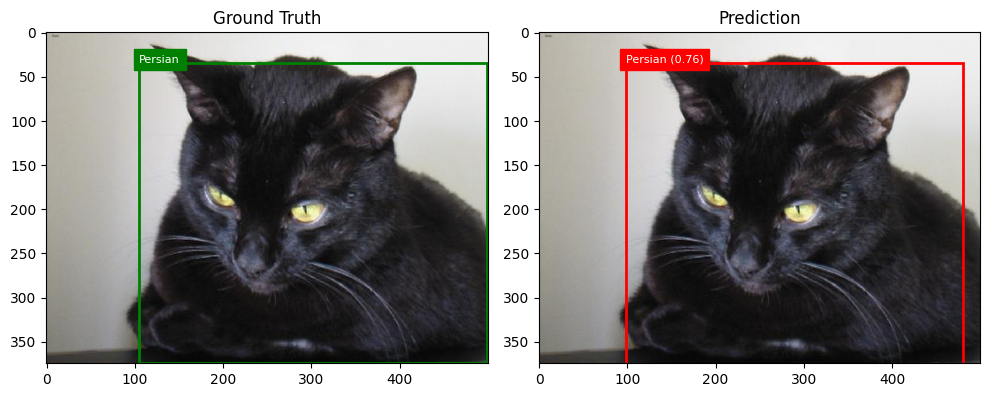

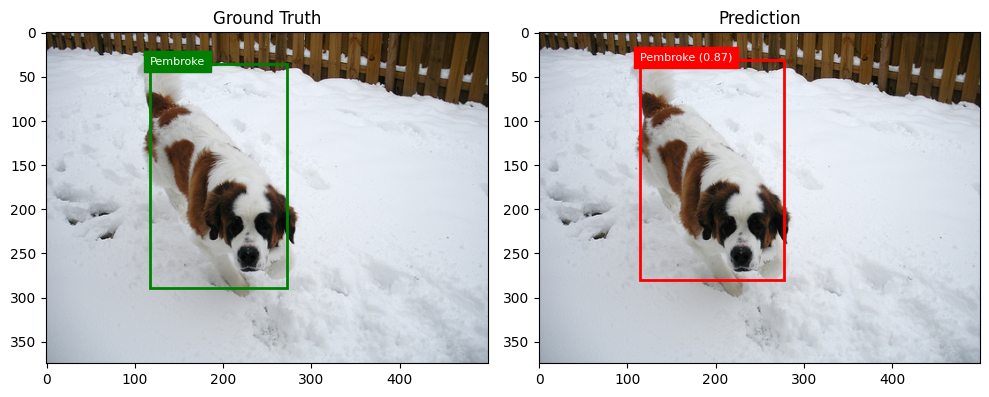

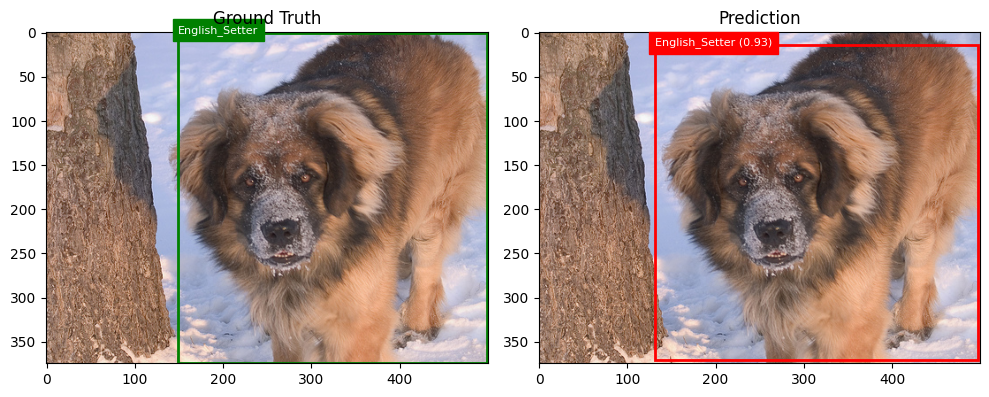

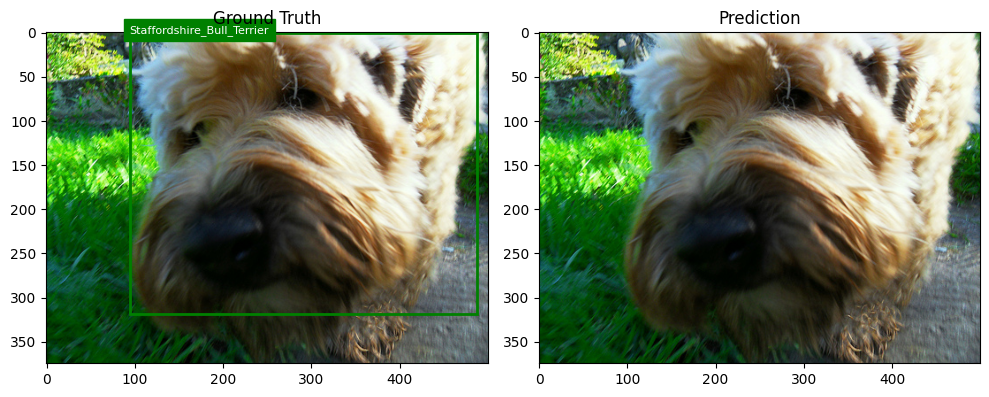

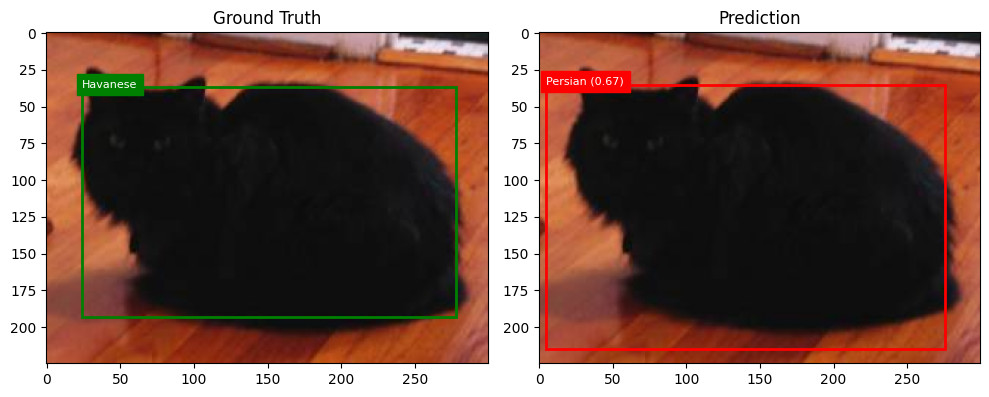

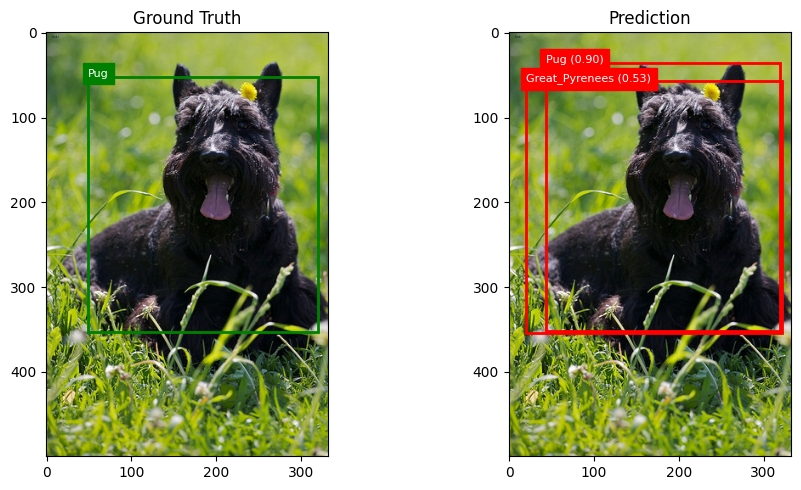

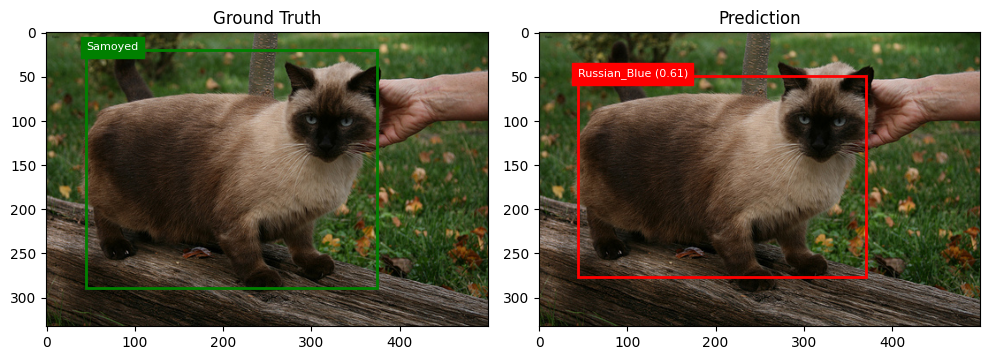

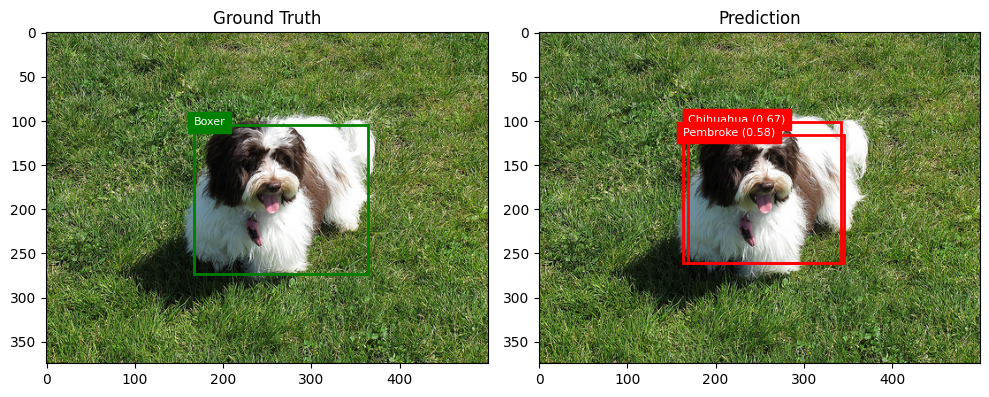

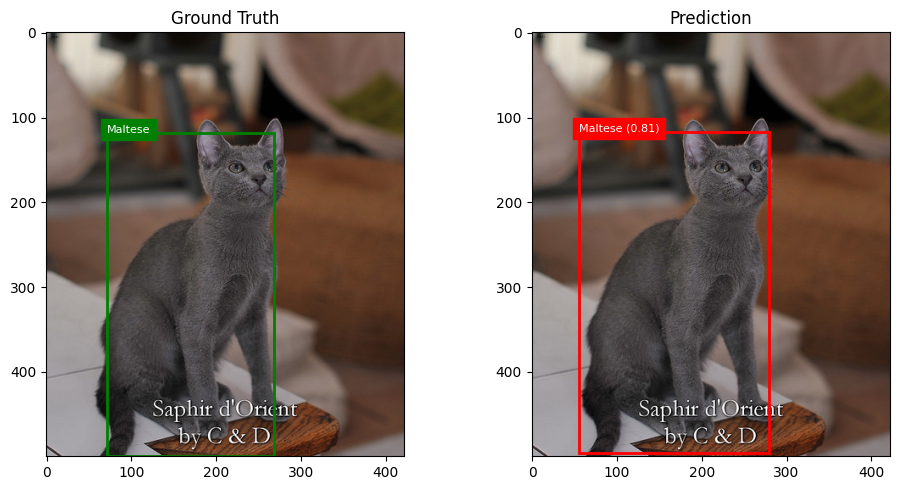

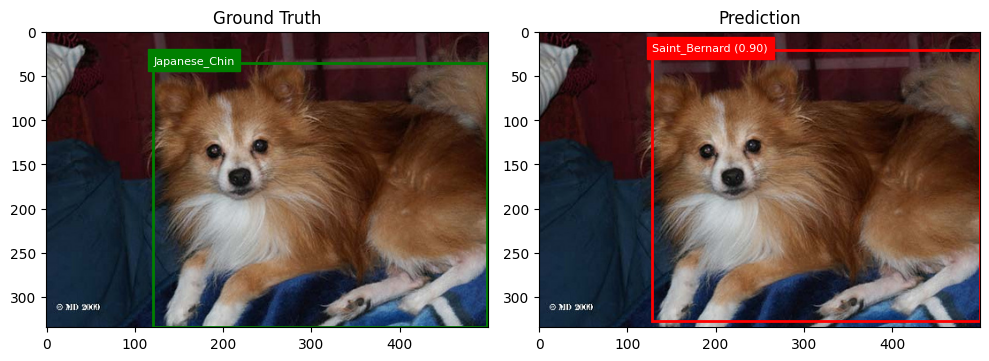

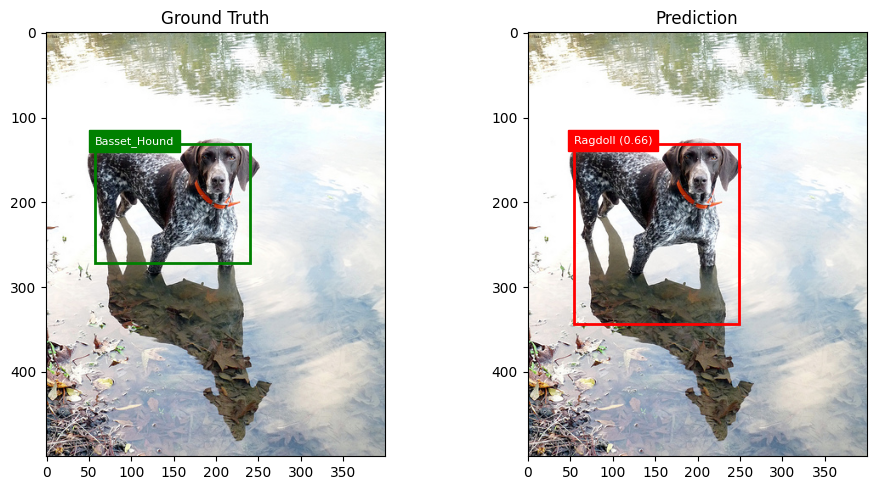

In [18]:
import random

model.eval()
num_samples = 20
indices = random.sample(range(len(test_dataset)), num_samples)

for idx in indices:
    img, target = test_dataset[idx]
    image_tensor = img.to(device).unsqueeze(0)
    
    with torch.no_grad():
        output = model(image_tensor)[0]

    # Prepare image
    img_np = img.permute(1, 2, 0).numpy()

    # Create subplot
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img_np)
    axs[0].set_title("Ground Truth")
    axs[1].imshow(img_np)
    axs[1].set_title("Prediction")

    # Ground truth boxes
    for box, label in zip(target['boxes'], target['labels']):
        xmin, ymin, xmax, ymax = box.cpu().numpy()  # fix: chuyển về cpu trước numpy
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='g', facecolor='none')
        axs[0].add_patch(rect)
        axs[0].text(xmin, ymin, idx_to_class.get(label.item(), 'Unknown'),
                    color='white', fontsize=8, backgroundcolor='green')

    # Predicted boxes (score > 0.5)
    score_mask = output['scores'] > 0.5
    pred_boxes = output['boxes'][score_mask]
    pred_labels = output['labels'][score_mask]
    pred_scores = output['scores'][score_mask]

    for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
        xmin, ymin, xmax, ymax = box.cpu().numpy()  # fix: chuyển về cpu trước numpy
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='r', facecolor='none')
        axs[1].add_patch(rect)
        axs[1].text(xmin, ymin, f"{idx_to_class.get(label.item(), 'Unknown')} ({score:.2f})",
                    color='white', fontsize=8, backgroundcolor='red')

    plt.tight_layout()
    plt.show()
